# Preprocessing and Benchmarking

By: Urban Halpern

Date: 12/5/2024

Original dataset can be found [here](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/data). We will be working with a subset of the data that only contains lung cancer histopathological images

In [ ]:
%%capture
!pip install -r requirements.txt

## Reading in Data from Dropbox

In [ ]:
import os
import requests
import tarfile

# URL to download your folder
url = "https://www.dropbox.com/scl/fi/arkoncxpl5y1dzmviivi2/lung_image_set.tar.gz?rlkey=716vzb9dyssledyxojmxy0kr0&st=qw4unm62&dl=1"

output_path = "/content/lung_image_set.tar.gz"

# Download the GZip folder
response = requests.get(url)
print(f"HTTP Response Code: {response.status_code}")

if response.status_code == 200:
    print("Download successful")
else:
    print(f"Failed to download file. HTTP status code: {response.status_code}")

with open(output_path, "wb") as f:
    f.write(response.content)

HTTP Response Code: 200
Download successful


In [ ]:
import tarfile

output_path = "/content/lung_image_set.tar.gz"
extract_path = "/content/"

# Extract the .tar.gz archive
if tarfile.is_tarfile(output_path):
    with tarfile.open(output_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete")
else:
    print(f"{output_path} is not a valid .tar.gz archive")

Extraction complete


## Preparing tabular dataset from extracted features

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import label, regionprops


For our tabular features, we will use skimage in order to extract the following features:
- **contrast**: measures local variation
  -  sum of squared differences between neighboring pixels. High contrast indicates a lot of variations (sharp edges), while low contrast indicates smooth variations.
- **homogeneity**: measures how similar neighboring pixel values are
  - Higher homogeneity means neighboring pixels have similar intensities
- **energy**: Measures the uniformity or the sum of squared elements in the GLCM matrix
  - Higher energy means fewer variations and a more uniform texture.
- **correlation**: Measures how correlated a pixel with its neighbor is
  - Higher correlation indicates strong relationships between neighboring pixel values
- **local binary pattern**:
  - For a given pixel, compare it with its surrounding 8 neighboring pixels.
  - Convert these comparisons into a binary number (0s and 1s) to form a binary pattern.
  - Count the frequency of these binary patterns across the image
- **morphological features**:
  - area: number of pixels within mask
  - perimeter: length of boundary around connected region
  - eccentricity: elongation of shape
  - solidity: compactness of shape
  - extent: proportion of bounding box occupied by connecting region

In [ ]:
# Define GLCM Feature Extraction
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    """
    Args:
      image: grayscale image to process
      distances: specifies number of pixels to consider to calculate GLCM
                 in this case, only consider immediate neighboring pixels
      angles: specifies directional relationships to consider when computing GLCM
              0 indicates horizontal (left to right) orientations
      levels: number of gray levels in the image, standard 8-bit grayscale
              has (0-225) --> 256 levels.

    Returns:
      features: dictionary of GLCM features

    Description:
      This function computes a Gray-Level Co-occurrence Matrix (GLCM).
      Using the matrix, it extracts texture features using the graycoprops
      method in order to input into a tabular dataset.
    """

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels)
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
    }
    return features

# Local Binary Pattern (LBP) Feature Extraction
def extract_lbp_features(image, radius=3, n_points=24):
    """
    Args:
      image: grayscale image to process
      radius: radius of the circular neighborhood
      n_points: number of points in the circular neighborhood

    Returns:
      features: dictionary of LBP features

    Description:
      For each pixel in the image, the function compares its intensity with its
      surrounding n_points neighbors. A binary pattern of 1s and 0s is created
      if the neighboring pixel has greater intesnity than the center or less than.


    """

    # returns an lbp pattern for each pixel in the input image
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    n_bins = int(lbp.max() + 1)

    # We flatten the lbp matrix into a 1D array and count the frequency of each pattern
    histogram, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))

    # Normalize histogram to sum to 1 so that features are symmetric across images
    histogram = histogram / histogram.sum()

    # create a feature for each bin in the histogram
    features = {f"lbp_bin_{i}": val for i, val in enumerate(histogram)}
    return features

# Morphological Feature Extraction
def extract_morphological_features(mask):
    """
    Args:
      mask: binary mask of the region of interest (0 or 255 intensity)

    Returns:
      features: dictionary of morphological features

    Description:
      Uses the regionprops method to extract morphological features
      from the image. If no regions are found, the features are set to 0.
    """
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    features = {}
    if regions:
        region = regions[0]
        features = {
            'area': region.area,
            'perimeter': region.perimeter,
            'eccentricity': region.eccentricity,
            'solidity': region.solidity,
            'extent': region.extent,
        }
    else:
        # set features to 0 if no regions are found
        features = {'area': 0, 'perimeter': 0, 'eccentricity': 0, 'solidity': 0, 'extent': 0}
    return features

# Process a Single Image and Extract Features
def process_image(cls, img_name, img_path):
    """
    Args:
      cls: class of the image
      img_name: name of the image
      img_path: path to the image

    Returns:
      combined_features (dict) combined glcm, lpb, and morphological features
      in a single dictionary
    """

    # using the OpenCV library to read an image into grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        return None

    # for each pixel, if inetensity is above 127, set to 255, else 0
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Extract all 3 sets of features
    glcm_features = extract_glcm_features(image)
    lbp_features = extract_lbp_features(image)
    morph_features = extract_morphological_features(binary_mask)

    # combine and return features
    combined_features = {
        'class': cls,
        'image_name': img_name,
        **glcm_features,
        **lbp_features,
        **morph_features
    }
    return combined_features

# Function to Process Images in a Subdirectory for a Class
def process_class(cls_dir, cls):
    """
    args:
      cls_dir: path to the class directory
      cls: class name
    returns:
      results: list of dictionaries containing features for each image in the class

    description:
      this intermediate function was created so that we can utilize each cpu core
      to process each class at the same time.
    """
    results = []
    count = 0

    # open the image and process
    # if successful, append to results
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        feature_data = process_image(cls, img_name, img_path)
        if feature_data:
            results.append(feature_data)

        count += 1
        if count % 500 == 0:
            print(f"{count} images processed for class {cls}")

    return results

# ain Multi-core Processing Function
def process_data(data_dir, classes, output_file):
    """
    args:
      data_dir: directory that contains original images
      classes: list of classes that pertain to the directory
      outputfile: path to save the output csv file

    description:
      for each class in classes, this function processed each class in parallel
      after processing is complete, the results are concatenated and saved to a csv
    """
    results = []
    with ProcessPoolExecutor() as executor:
        future_to_class = {
            executor.submit(process_class, os.path.join(data_dir, cls), cls): cls for cls in classes
        }
        for future in future_to_class:
            cls = future_to_class[future]
            class_results = future.result()
            results.extend(class_results)

    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"Features saved to {output_file}")


In [ ]:
data_dir = '/content/content/lung_image_sets'   # replace with your dataset directory path
output_file = 'image_features.csv'
classes = ['lung_scc', 'lung_n', 'lung_aca']

process_data(data_dir, classes, output_file)


500 images processed for class lung_scc
500 images processed for class lung_n
500 images processed for class lung_aca
1000 images processed for class lung_scc
1000 images processed for class lung_aca
1000 images processed for class lung_n
1500 images processed for class lung_scc
1500 images processed for class lung_aca
1500 images processed for class lung_n
2000 images processed for class lung_scc
2000 images processed for class lung_aca
2000 images processed for class lung_n
2500 images processed for class lung_scc
2500 images processed for class lung_aca
2500 images processed for class lung_n
3000 images processed for class lung_scc
3000 images processed for class lung_aca
3000 images processed for class lung_n
3500 images processed for class lung_scc
3500 images processed for class lung_aca
3500 images processed for class lung_n
4000 images processed for class lung_scc
4000 images processed for class lung_aca
4000 images processed for class lung_n
4500 images processed for class lun

## Preparing Image Dataset for Benchmark

### Create DF for converting images into tensors

In [ ]:
import os
import pandas as pd

# Step 2: Define the function for loading data
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names (e.g., lung_aca, lung_n, lung_scc)
    folds = os.listdir(data_dir)

    print(folds)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        print(len(filelist))
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
data_dir = '/content/content/lung_image_sets'

# Step 5: Load the data and apply label changes
df = loading_the_data(data_dir)


# Display the DataFrame
print(len(df))
df.head()

['lung_scc', 'lung_aca', 'lung_n']
5000
5000
5000
15000


,filepaths,labels
0,/content/content/lung_image_sets/lung_scc/lung...,lung_scc
1,/content/content/lung_image_sets/lung_scc/lung...,lung_scc
2,/content/content/lung_image_sets/lung_scc/lung...,lung_scc
3,/content/content/lung_image_sets/lung_scc/lung...,lung_scc
4,/content/content/lung_image_sets/lung_scc/lung...,lung_scc


### Creating a new folder with resized images for greater efficiency

In [ ]:
from PIL import Image
from tqdm import tqdm
import torch
from torchvision.transforms import v2
from PIL import Image

In [ ]:
# Target directory
output_base_dir = '/content/pre_processed_tensors'
os.makedirs(output_base_dir, exist_ok=True)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a PyTorch transform for resizing
transform = v2.Compose([
    v2.Resize((299, 299)),  # Resize to 299x299
    v2.ToTensor(),          # Convert to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to process and save tensors
def process_image(row):
    input_path = row['filepaths']
    label = row['labels']
    label_dir = os.path.join(output_base_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    output_path = os.path.join(label_dir, os.path.basename(input_path).replace(".jpeg", ".pt"))

    try:
        # Open image and apply transform
        image = Image.open(input_path).convert("RGB")  # Ensure 3 channels (RGB)
        tensor_image = transform(image)

        # Move the tensor to the GPU
        tensor_image = tensor_image.to(device)

        # Save the tensor to a .pt file
        torch.save(tensor_image, output_path)
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

# Apply processing with a progress bar
tqdm.pandas()
df.progress_apply(process_image, axis=1)

print("Preprocessing complete. Tensors saved.")


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Using device: cuda


100%|██████████| 15000/15000 [02:42<00:00, 92.48it/s]

Preprocessing complete. Tensors saved.


Create a dataframe with the tensor filepaths

In [ ]:
data_dir = '/content/pre_processed_tensors'

# Step 5: Load the data
df_preprocessed = loading_the_data(data_dir)

# Display the DataFrame
print(len(df_preprocessed))
df_preprocessed.head()

['lung_scc', 'lung_aca', 'lung_n']
5000
5000
5000
15000


,filepaths,labels
0,/content/pre_processed_tensors/lung_scc/lungsc...,lung_scc
1,/content/pre_processed_tensors/lung_scc/lungsc...,lung_scc
2,/content/pre_processed_tensors/lung_scc/lungsc...,lung_scc
3,/content/pre_processed_tensors/lung_scc/lungsc...,lung_scc
4,/content/pre_processed_tensors/lung_scc/lungsc...,lung_scc


Next we want to split the dataset into train, validation, and test while keeping an equal number of classes in each split

In [ ]:
from sklearn.model_selection import train_test_split

# split train_val into 80% train and 20% test
train_val_df, test_df = train_test_split(df_preprocessed, test_size=0.2, random_state=42, stratify=df_preprocessed['labels'])

# split train_val into 80% train and 20% validation
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['labels'])


All lung cancer images were successfully loaded with their corresponding labels. Now we can turn each image into a tensor.

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, Subset
from torchvision.transforms import v2
from PIL import Image
import pandas as pd

The following code loads the images into a pytorch Dataloader to easily shuffle the data and do batch processing

In [ ]:

class ImageDatasetToTensor(Dataset):
    def __init__(self, dataframe, transform=None, test_set=False, device=None):
        """
        Args:
            dataframe (pandas dataframe): Contains image paths and labels
            transform (callable, optional): Optional transform to be applied
                on a sample.

        """
        self.dataframe = dataframe
        self.transform = transform
        self.test_set = test_set
        self.device = device if device else torch.device("cpu")

        self.label_mapping = {
            'lung_aca': 0,
            'lung_scc': 1,
            'lung_n': 2
        }

    def __len__(self):
        return len(self.dataframe)

    # Retrieves sample and its label based on index idx
    def __getitem__(self, idx):
      # convert to list for indexing if converted to tensor during batching
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tensor_path = self.dataframe.iloc[idx]['filepaths']  # Assuming file_paths is in the first column
        #image = Image.open(f"{img_path}").convert('RGB') # Convert if in other format like grayscale
        image = torch.load(f"{tensor_path}", map_location=self.device)  # Load directly onto the target device

        if self.transform:
            image = self.transform(image)

        # return image and not label
        if self.test_set:
          return image

        label = torch.tensor(self.label_mapping[self.dataframe.iloc[idx]['labels']], dtype=torch.long)  # Assuming label is in the second column
        return image, label

# Create separate datasets for training and validation
train_dataset = ImageDatasetToTensor(train_df, transform=False)
val_dataset = ImageDatasetToTensor(val_df, transform=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, shuffle=False) # do not shuffle validation set

We can verify the batch size of each Dataloader instance

In [ ]:
for inputs, labels in train_dataloader:
    print("Input batch size:", inputs.shape)  # Shape of the input batch
    print("Label batch size:", labels.shape)  # Shape of the labels
    break  # Check only the first batch

Input batch size: torch.Size([32, 3, 299, 299])
Label batch size: torch.Size([32])


<ipython-input-32-85ba8430714d>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(f"{tensor_path}", map_location=self.device)  # Load directly onto the ta

## Training Benchmark CNN Model

Now we will fintune inception_v3 to get a benchamrk accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def log_training(log_df, iteration_id, learning_rate, weight_decay, optimizer_name, num_unfrozen_layers,
                  num_epochs, early_stopping_patience, early_stopping_min_delta,
                  stopped_epoch, training_loss_arr, val_loss_arr, val_accuracy,
                  log_filename="target_training_log.csv"):
    """
    Args:
      log_df: dataframe template that defines csv output structure
      hyperparameters: (iteration_id - early_stopping_min_delta) hyperparameters to keep track of
      evaluation metrics: (stopped_epoch - val_accuracy) metrics to track
      log_filename: name of csv file to write to

    Description:
      After each training iteration, this function will be called to create a history
      of models created defined by their hyperparameters and evaluated on validation accuracy
    """
    new_log_data = {
        "iteration_id": iteration_id,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "optimizer": optimizer_name,
        "num_unfrozen_layers": num_unfrozen_layers,
        "num_epochs": num_epochs,
        "early_stopping_patience": early_stopping_patience,
        "early_stopping_min_delta": early_stopping_min_delta,
        "stopped_epoch": stopped_epoch,
        "training_loss": training_loss_arr,  # Full training loss history
        "validation_loss": val_loss_arr,    # Full validation loss history
        "validation_accuracy": val_accuracy  # Final validation accuracy
    }

    # Append new data to DataFrame
    log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)

    # Append to a CSV file each time training is completed
    if os.path.exists(log_filename):
        log_df.to_csv(log_filename, index=False, mode='a', header=False)
    else:
        log_df.to_csv(log_filename, index=False)

# Initialize logging
log_df = pd.DataFrame(columns=[
    "iteration_id", "learning_rate", "weight_decay","optimizer", "num_unfrozen_layers",
    "num_epochs", "early_stopping_patience", "early_stopping_min_delta",
    "stopped_epoch", "training_loss", "validation_loss", "validation_accuracy"
])

In [ ]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience # epochs of no improvement before terminating
    self.min_delta = min_delta # validation_loss needs to be within this threshold from min
    self.counter = 0
    self.min_validation_loss = float("inf") # initial value to infinity

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
iteration_id = 1
learning_rate = 1e-3
weight_decay = None
optimizer_name = "Adam"
num_unfrozen_layers = 2
early_stopping_patience = 2
early_stopping_min_delta = 0.005
num_epochs = 2  # Maximum number of epochs
stopped_epoch = num_epochs  # Default value

# Fine tune a pre-trained model
from torchvision import models

num_classes = 3

# Load a pre-trained model
model_transfer = models.inception_v3(weights=True)

# Modify the final fully connected layer
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, num_classes)  # Replace with your number of classes

# Freeze early layers (optional)
# Prevents layers from being updated during backpropagation
for param in model_transfer.parameters():
    param.requires_grad = False

 # Unfreeze later layers (optional)
 # allow finetuning of later layers
for layer in list(model_transfer.children())[-num_unfrozen_layers:]:  # Unfreeze last 10 layer
    for param in layer.parameters():
        param.requires_grad = True

# 4. Define optimizer and loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()),
                      lr=learning_rate)

#criterion1 = nn.CrossEntropyLoss(weight=weights_tensor)
criterion2 = nn.CrossEntropyLoss()

# 5. Create DataLoader
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 6. Train the model (similar to previous example)
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfer.to(device)
early_stopper = EarlyStopper(patience=early_stopping_patience, min_delta=early_stopping_min_delta)

training_loss_arr = []
val_loss_arr = []

best_model = model_transfer

# start training
for epoch in range(num_epochs):

    # set model to training mode
    model_transfer.train()

    # define loss variables for logging
    running_loss = 0.0
    average_train_loss = 0
    epoch_loss = 0

    # for batch in dataloader, get model output and compute loss
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model_transfer(inputs)
        main_output, aux_output = outputs  # Extract the outputs

        loss = criterion2(main_output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches # i % 100 == 99
            print(f"[{epoch + 1}, {i + 1}] training_loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    average_train_loss = epoch_loss / len(train_dataloader)

    model_transfer.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    min_val_loss = 999

    # after each batch evaluate on validation set
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model_transfer(inputs)

            loss = criterion2(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total

    if avg_val_loss < min_val_loss:
      min_val_loss = avg_val_loss
      best_model = model_transfer

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    training_loss_arr.append(average_train_loss)
    val_loss_arr.append(avg_val_loss)

    if early_stopper.early_stop(avg_val_loss):
        print("Early stopping triggered")
        break

log_training(
    log_df, iteration_id, learning_rate, weight_decay, optimizer_name, num_unfrozen_layers,
    num_epochs, early_stopping_patience, early_stopping_min_delta,
    stopped_epoch, training_loss_arr, val_loss_arr, val_accuracy
)

print("Finished Training")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-32-85ba8430714d>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be load

[1, 100] training_loss: 0.551
[1, 200] training_loss: 0.306
[1, 300] training_loss: 0.249
Validation Loss: 0.1703, Validation Accuracy: 94.83%
[2, 100] training_loss: 0.243
[2, 200] training_loss: 0.225
[2, 300] training_loss: 0.228
Validation Loss: 0.1360, Validation Accuracy: 95.62%
Finished Training


<ipython-input-42-567801ead5b3>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)


When intializing weights, probabilities are around 1/54 for every single class. You can assign weights to a sample. This will multiply the loss function by the sample weight. For example, a sample of class 35 has 1 datapoint. Can assign a weight of 2 which will multiply the loss by 2.

In [ ]:
avg_validation = np.array(val_loss_arr).mean()
avg_validation

0.15311633223716398

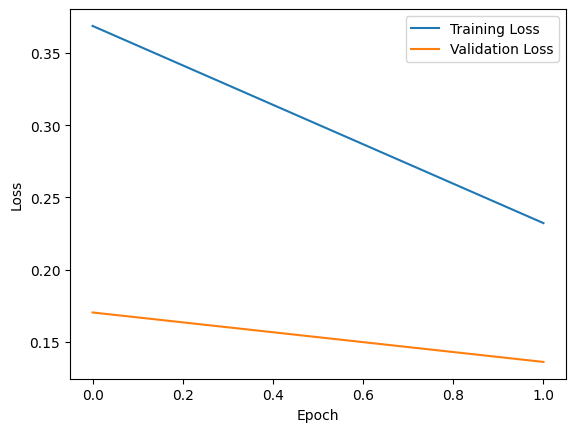

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_loss_arr, label='Training Loss')
plt.plot(val_loss_arr, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
test_dataset = ImageDatasetToTensor(test_df, transform=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

## Evaluate the Benchmark on the held out testset

In [ ]:
# Place model in evaluation mode
model_transfer.eval()

# Initialize confusion matrix
num_classes = 3
conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)

correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model_transfer(inputs)
        _, predicted = torch.max(outputs, 1)

        # updating confusion matrix
        for label, pred in zip(labels.cpu(), predicted.cpu()):
            conf_matrix[label, pred] += 1

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total

print(f"Confusion Matrix:\n{conf_matrix}")

# calculate precision, recall, and F1 for each class
for i in range(num_classes):
    TP = conf_matrix[i, i].item()
    FP = conf_matrix[:, i].sum().item() - TP
    FN = conf_matrix[i, :].sum().item() - TP
    TN = total - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"\nClass {i}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (TPR): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

print(f"\nOverall Test Accuracy: {accuracy:.2f}%")


<ipython-input-32-85ba8430714d>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(f"{tensor_path}", map_location=self.device)  # Load directly onto the ta

Confusion Matrix:
tensor([[ 929,   68,    3],
        [  46,  954,    0],
        [   0,    0, 1000]])

Class 0:
Precision: 0.9528
Recall (TPR): 0.9290
Specificity: 0.9770

Class 1:
Precision: 0.9335
Recall (TPR): 0.9540
Specificity: 0.9660

Class 2:
Precision: 0.9970
Recall (TPR): 1.0000
Specificity: 0.9985

Overall Test Accuracy: 96.10%


Plot the confusion matrix with an sns heatmap

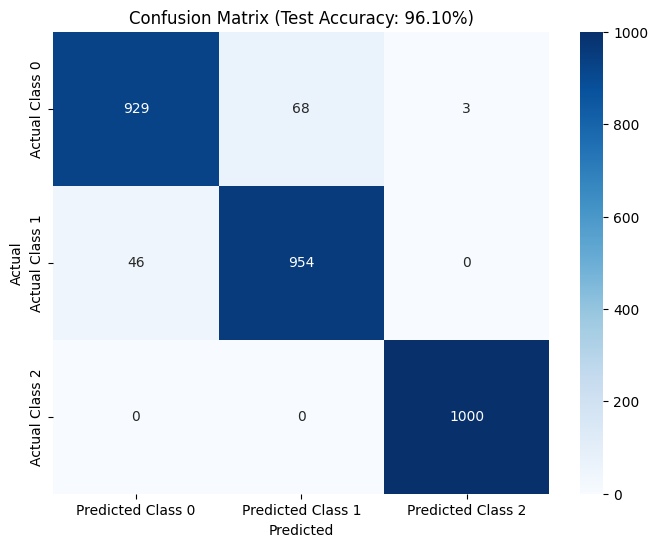

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.title(f"Confusion Matrix (Test Accuracy: {accuracy:.2f}%)")
sns.heatmap(conf_matrix.cpu().numpy(), annot=True, fmt='d', cmap='Blues',
           xticklabels=[f'Predicted Class {i}' for i in range(num_classes)],
           yticklabels=[f'Actual Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Class Mapping:
- 0: Lung adenocarcinoma (lung_aca)
- 1: Lung squamous cell carcinoma (lung_scc)
- 2: Lung benign tissue (lung_n)

In [ ]:
#!mv /content/benchmark_training_log.csv /content/drive/MyDrive/ng_